# Tour de France Time Series Analysis

Have winning time gaps been decreasing over time?

In [33]:
import os
import adtk
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt

from adtk.visualization import plot
from adtk.data import validate_series
from adtk.transformer import RollingAggregate, DoubleRollingAggregate
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

## Prepare Data

In [2]:
df = pd.read_csv("../data/tdf_cleaned.csv")
winning_gaps_df = pd.read_csv("../data/winning_time_gaps.csv")
all_gaps_df = pd.read_csv("../data/all_time_gaps.csv")

In [15]:
winning_gaps_df['Year DT'] = pd.to_datetime(winning_gaps_df['Year'])

In [23]:
winning_gaps_ts_df = winning_gaps_df.set_index('Year DT')

In [5]:
X = pd.DataFrame(winning_gaps_df['Year'])
y = winning_gaps_df['Time Gap']

### Plotting df 

With gaps during WW2

## Test for stationarity

H0: The time series is non-stationary

H1: The time series is stationary

In [6]:
adf_gap = adfuller(winning_gaps_df['GapSeconds'])

print('ADF Statistic:', adf_gap[0])
print('p-value:', adf_gap[1])
print('Critical Values:', adf_gap[4])

ADF Statistic: -7.574982107459977
p-value: 2.7769632027487447e-11
Critical Values: {'1%': -3.431033638718364, '5%': -2.861842126144868, '10%': -2.566930816636996}


## Linear Model

The regression line is negative, indicating a decreasing trend

In [7]:
reg = LinearRegression()
reg.fit(X, y)

reg.coef_, reg.intercept_

(array([-218.44112196]), 444041.9827121048)

Plotting the regression line over the data, however, shows that this is a poor fit

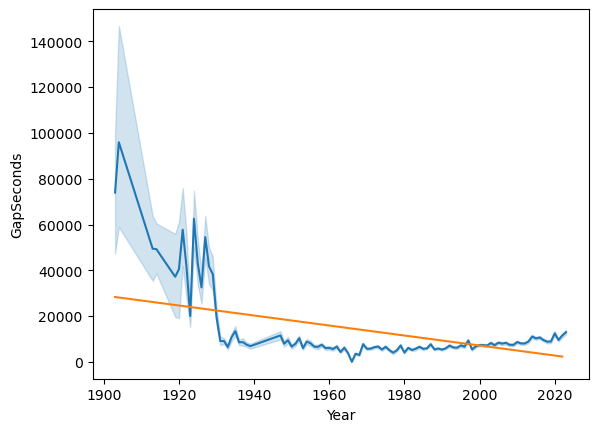

In [9]:
reg_x = np.arange(min(winning_gaps_df['Year']), max(winning_gaps_df['Year']))

sns.lineplot(winning_gaps_df, x = 'Year', y ='GapSeconds')
plt.plot(reg_x, (reg.coef_ * reg_x) + reg.intercept_)

## Kendall Tau

p < 0.05, we see moderate disagreement between X and y. In other words, evidence shows the winning time gap decreases with time.

In [11]:
tau, p_val = stats.kendalltau(X, y)

tau, p_val

(0.06863062238389628, 1.1522933126985639e-23)

## Trend Change

In [25]:
s = validate_series(winning_gaps_ts_df['Time Gap'])

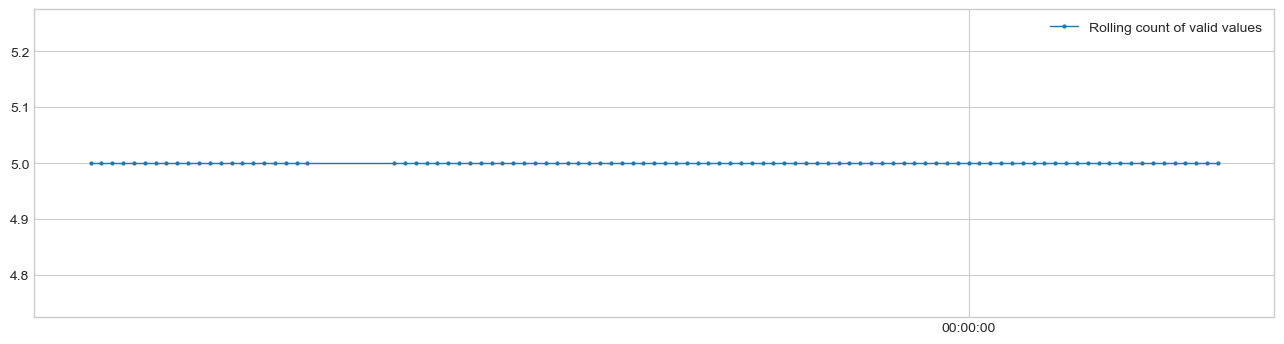

In [31]:
s_transformed = RollingAggregate(agg='count', window=5).transform(s)
plot(s_transformed.rename("Rolling count of valid values"), ts_linewidth=1, ts_markersize=4);

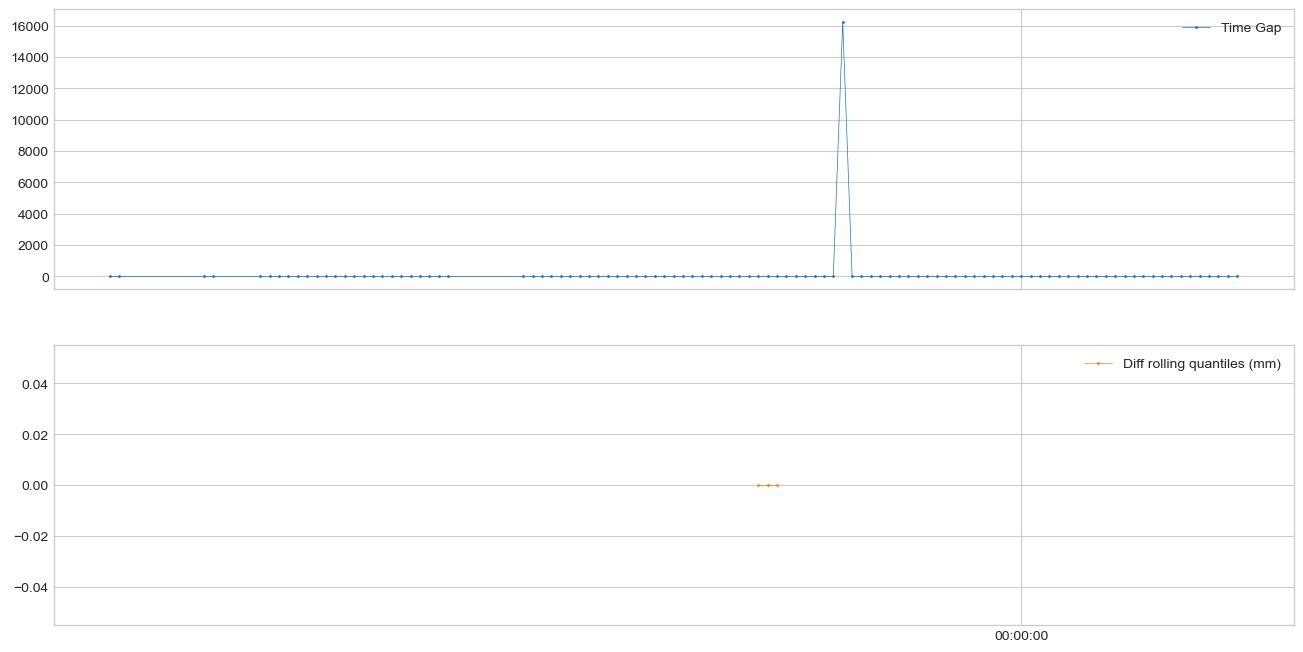

In [34]:
s_transformed = DoubleRollingAggregate(
    agg="quantile",
    agg_params={"q": [0.1, 0.5, 0.9]},
    window=50,
    diff="l2").transform(s).rename("Diff rolling quantiles (mm)")

plot(pd.concat([s, s_transformed], axis=1));